# Principal components analysis of mutant motility
---

### Overview
The purpose of this notebook is ...

TODO: things to mention
- only includes motility data from cells 2 hours in drugs
- PCA projections are from motility data from highest (50 µL ?) concentration

In [1]:
from pathlib import Path

import arcadia_pycolor as apc
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

apc.mpl.setup()

In [2]:
# TODO: fix this
import sys

src_path = "../src"

if src_path not in sys.path:
    sys.path.insert(1, src_path)

In [3]:
from stats_testing import kde_plot_with_stats, joint_grid_with_stats

### Define variables
- Define wild-typle vs mutant strains.
- Define controls vs drugs.
- Define which motility metrics to include in the PCA.

In [4]:
# strains
wild_type = "CC-125"
mutant_strains = ["CC-2670", "CC-3707"]

# drugs
controls = ["dmso", "h2o"]
drugs = ["atp", "dyn", "ibu", "lin", "tak", "tor"]

# motility metrics
metrics = [
    "max_sprint_length",
    "confinement_ratio",
    "mean_curvilinear_speed",
    "mean_linear_speed",
    "mean_angular_speed",
    "pivot_rate",
]

# rename certain variables in the plots
rename_for_plot = {
    "CC-125": "wild type",
    "CC-2670": "ida4 mutant",
    "CC-3707": "cpc1 mutant",
    "max_sprint_length": "Max sprint length",
    "confinement_ratio": "Confinement ratio",
    "mean_curvilinear_speed": "Mean curvilinear speed",
    "mean_linear_speed": "Mean linear speed",
    "mean_angular_speed": "Mean angular speed",
    "pivot_rate": "Pivot rate",
}

# define color palette
color_palette = {
    "wild type": apc.chateau,
    "ida4 mutant": apc.vital,
    "cpc1 mutant": apc.tangerine,
}
ida4_mutant_colors = {
    f"ida4 mutant + {drug}": color
    for drug, color in zip(drugs, [apc.lapis] * len(drugs), strict=True)
}
cpc1_mutant_colors = {
    f"cpc1 mutant + {drug}": color
    for drug, color in zip(drugs, [apc.dragon] * len(drugs), strict=True)
}
color_palette = {
    **color_palette,
    **ida4_mutant_colors,
    **cpc1_mutant_colors,
}

color_palette

{'wild type':    chateau #BAB0A8,
 'ida4 mutant':    vital #73B5E3,
 'cpc1 mutant':    tangerine #FFB984,
 'ida4 mutant + atp':    lapis #2B65A1,
 'ida4 mutant + dyn':    lapis #2B65A1,
 'ida4 mutant + ibu':    lapis #2B65A1,
 'ida4 mutant + lin':    lapis #2B65A1,
 'ida4 mutant + tak':    lapis #2B65A1,
 'ida4 mutant + tor':    lapis #2B65A1,
 'cpc1 mutant + atp':    dragon #C85152,
 'cpc1 mutant + dyn':    dragon #C85152,
 'cpc1 mutant + ibu':    dragon #C85152,
 'cpc1 mutant + lin':    dragon #C85152,
 'cpc1 mutant + tak':    dragon #C85152,
 'cpc1 mutant + tor':    dragon #C85152}

### Load summary motility statistics

In [5]:
motility_csv = Path("../data/summary_motility_statistics_20240425_174057_487.csv")
motility_dataframe = pd.read_csv(motility_csv)

hours_in_drug = motility_dataframe["hours_in_drug"].unique().tolist()
concentrations = motility_dataframe["concentration"].unique().tolist()

motility_dataframe.head()

,total_time,total_distance,net_distance,max_sprint_length,confinement_ratio,mean_curvilinear_speed,mean_linear_speed,mean_angular_speed,num_rotations,num_direction_changes,pivot_rate,cell_count,strain,drug,hours_in_drug,concentration,well_ID
0,20.704225,230.867728,147.046824,7.562634,0.636931,11.150754,7.102262,1.526070,2.0,17,0.073635,15,CC-125,tor,2,12.5,WellA01
1,11.901408,382.449800,125.138478,17.248704,0.327202,32.134835,10.514594,2.686931,2.0,21,0.054909,15,CC-125,tor,2,12.5,WellA01
2,20.704225,156.499828,110.772470,7.823802,0.707812,7.558835,5.350235,2.427813,2.0,34,0.217253,15,CC-125,tor,2,12.5,WellA01
3,20.704225,411.206653,164.362285,12.917934,0.399707,19.861002,7.938587,1.467109,1.0,16,0.038910,15,CC-125,tor,2,12.5,WellA01
4,20.704225,154.341462,107.157320,6.164652,0.694287,7.454588,5.175626,2.173751,0.0,26,0.168458,15,CC-125,tor,2,12.5,WellA01


## Construct PCA
---

### Build PC-space on wild-type and mutant motility in controls

In [6]:
# filter dataframe to only include motility metrics stats in controls
motility_dataframe_controls = motility_dataframe.loc[
    motility_dataframe["drug"].isin(controls)
].copy()

# apply min-max normalization to the data
metrics_controls = motility_dataframe_controls.loc[:, metrics]
minmax_range = metrics_controls.max() - metrics_controls.min()
metrics_controls_normalized = (metrics_controls - metrics_controls.min()) / minmax_range

# create and fit PCA
pca_controls = PCA(n_components=2)
motility_components = pca_controls.fit_transform(metrics_controls_normalized)

# add principal components to dataframe
for i in range(pca_controls.n_components_):
    key = f"PC-{i + 1}"
    motility_dataframe_controls[key] = motility_components[:, i]

### Visualize principal components and compare WT vs each mutant with statistical tests

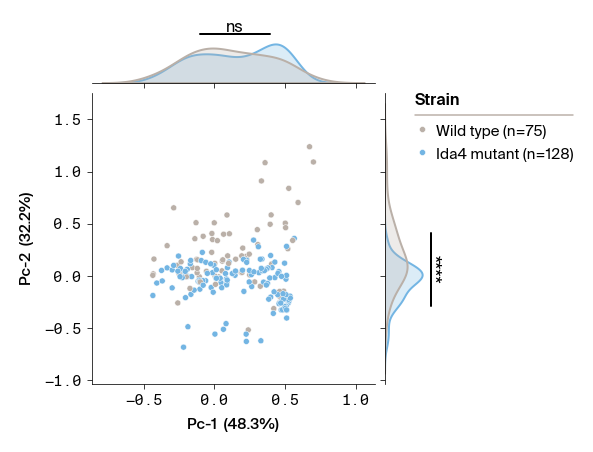

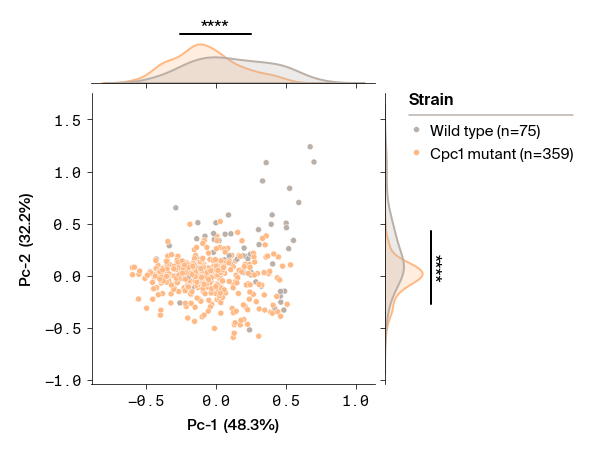

In [7]:
for mutant_strain in mutant_strains:

    source = motility_dataframe_controls.loc[
        motility_dataframe_controls["strain"].isin([wild_type, mutant_strain])
    ].copy()
    source["strain"] = source["strain"].map(rename_for_plot)

    # render JointGrid
    joint_grid = joint_grid_with_stats(
        data=source,
        x_variable="PC-1",
        y_variable="PC-2",
        hue_variable="strain",
        palette=color_palette,
    )

    # aesthetics
    variances = pca_controls.explained_variance_ratio_
    joint_grid.ax_joint.set_xlabel(f"PC-1  ({variances[0]:.1%})")
    joint_grid.ax_joint.set_ylabel(f"PC-2  ({variances[1]:.1%})")
    sns.move_legend(joint_grid.ax_joint, "upper right", bbox_to_anchor=(1.7, 1))
    apc.mpl.style_plot(joint_grid.ax_joint, monospaced_axes="both")

### Visualize weights of the principal components

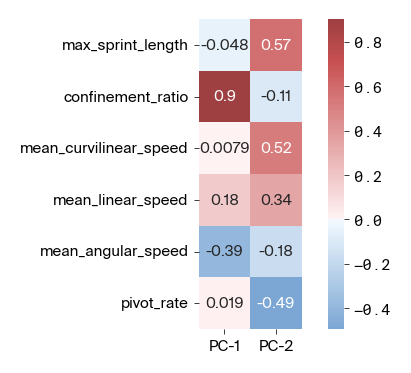

In [8]:
cmap = apc.gradients.red_blue.reverse().to_mpl_cmap()

# create figure
figsize = apc.mpl.get_figure_dimensions("float_wide")
fig, ax = plt.subplots(figsize=figsize, layout="constrained")

# create heatmap
ax = sns.heatmap(
    pca_controls.components_.T,
    cmap=cmap,
    xticklabels=[f"PC-{i}" for i in range(1, pca_controls.n_components_ + 1)],
    yticklabels=metrics,
    annot=True,
    square=True,
    cbar=True,
    center=0,
    ax=ax,
)

# figure aesthetics
apc.mpl.style_plot(colorbar_exists=True)

## PCA projections
---
Project summary motility statistics from mutant strains on drugs into the PC-space constructed on the wild type and mutant controls.

### Joint distributions (first two principal components)

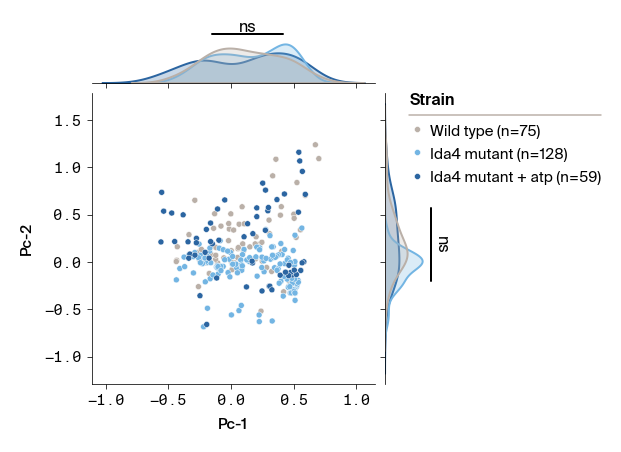

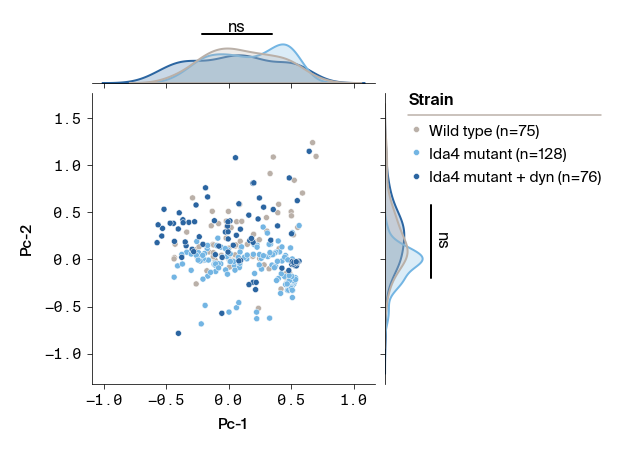

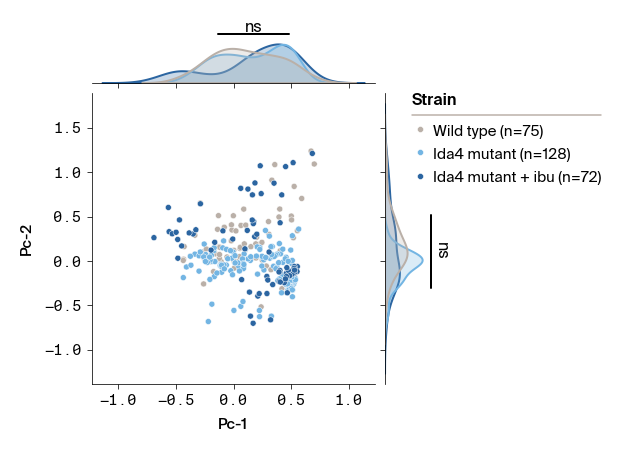

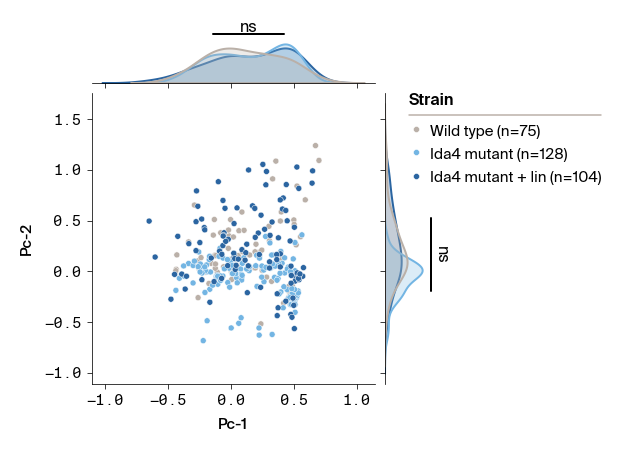

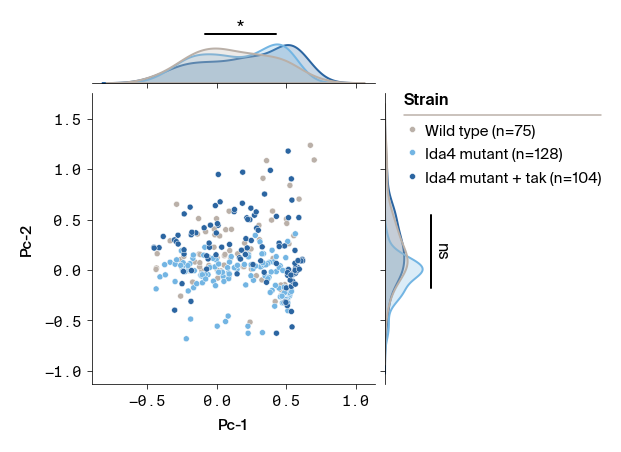

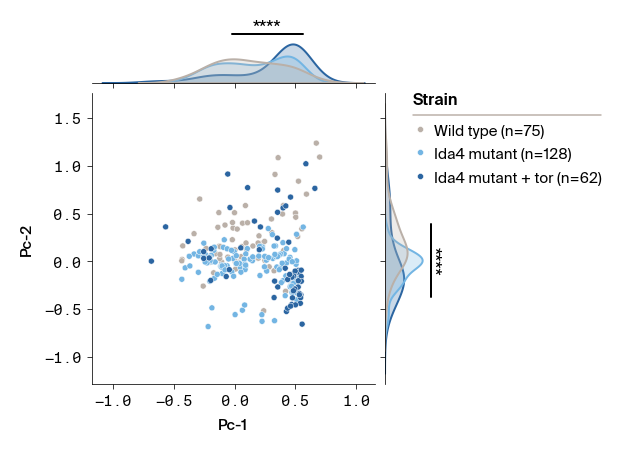

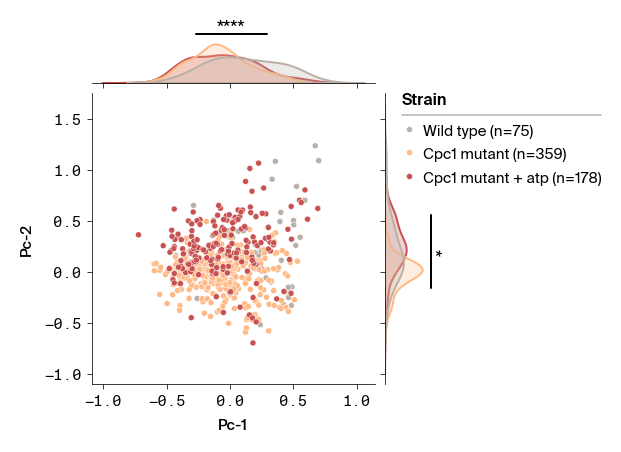

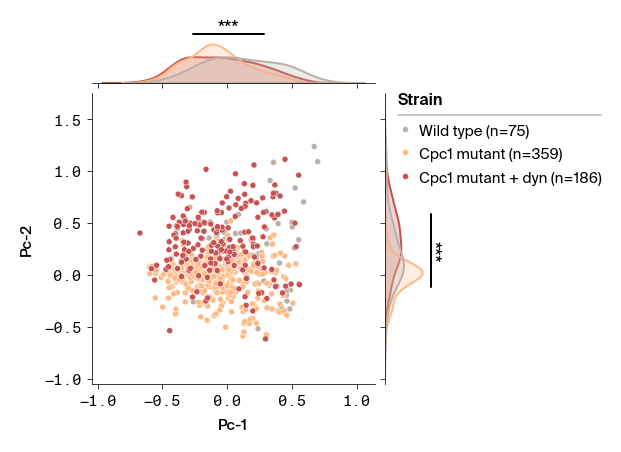

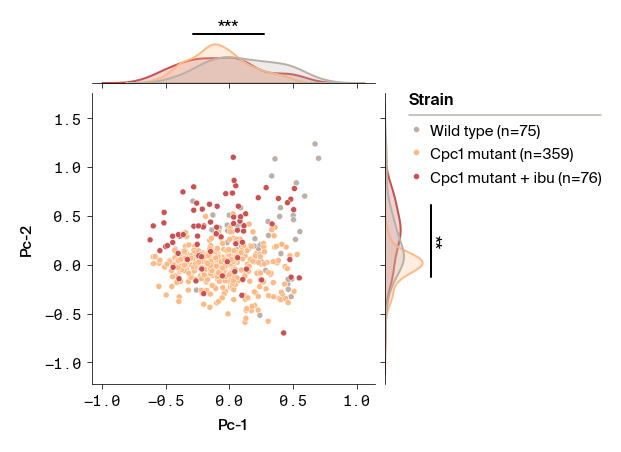

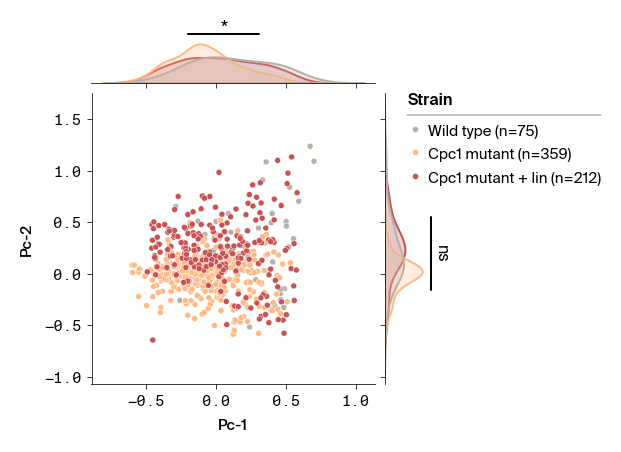

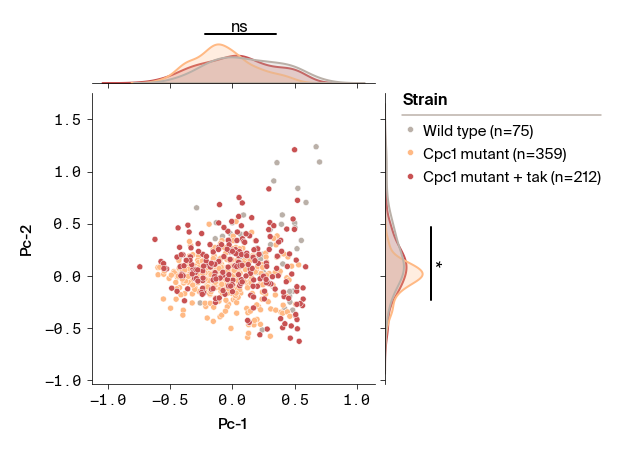

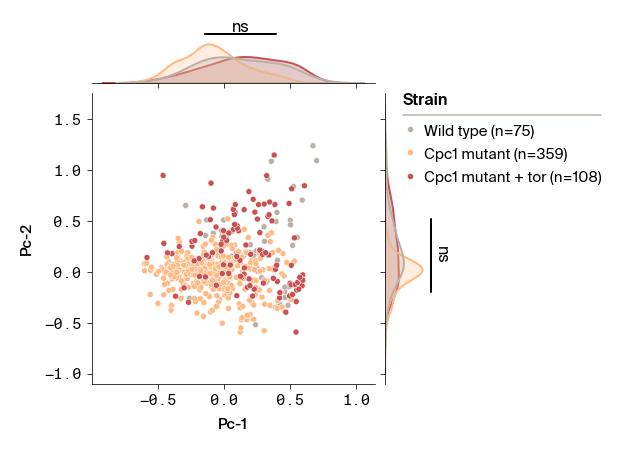

In [9]:
# create filtered dataframe of motility data from wild type cells in controls
motility_dataframe_controlled_wildtype = motility_dataframe_controls.loc[
    motility_dataframe_controls["strain"] == wild_type
]

for mutant_strain in mutant_strains:
    # create filtered dataframe of motility data from mutant cells in controls
    motility_dataframe_controlled_mutant = motility_dataframe_controls.loc[
        motility_dataframe_controls["strain"] == mutant_strain
    ]

    for drug in drugs:
        # create filtered dataframe of motility data from mutant cells on each drug
        motility_dataframe_drugged_mutant = motility_dataframe.loc[
            (motility_dataframe["strain"] == mutant_strain) & (motility_dataframe["drug"] == drug)
        ].copy()

        # apply min-max normalization to the data
        metrics_drugged_mutants = motility_dataframe_drugged_mutant.loc[:, metrics]
        minmax_range = metrics_drugged_mutants.max() - metrics_drugged_mutants.min()
        metrics_drugged_mutants_normalized = (
            metrics_drugged_mutants - metrics_drugged_mutants.min()
        ) / minmax_range

        # project mutant + drug motility into PC space of wild type + controls
        motility_components = pca_controls.transform(metrics_drugged_mutants_normalized)

        # add principal components to dataframe
        num_components = motility_components.shape[1]
        for i in range(num_components):
            key = f"PC-{i + 1}"
            motility_dataframe_drugged_mutant[key] = motility_components[:, i]

        # combine groups whose motility we want to examine
        source = pd.concat(
            [
                motility_dataframe_controlled_wildtype,
                motility_dataframe_controlled_mutant,
                motility_dataframe_drugged_mutant,
            ]
        )

        # give each of the three groups unique labels so they can be separated in the plot
        source["Strain"] = source["strain"].map(rename_for_plot)
        for i, row in source.iterrows():
            if row["drug"] in drugs:
                source.loc[i, "Strain"] += f" + {drug}"
        # define groups for statistical tests -- only want to compare wild type and mutant + drug
        a = f"{rename_for_plot[mutant_strain]} + {drug}"
        groups = ["wild type", a]

        # plot the joint distributions for the first two principal components
        joint_grid = joint_grid_with_stats(
            data=source,
            x_variable="PC-1",
            y_variable="PC-2",
            hue_variable="Strain",
            groups=groups,
            palette=color_palette,
        )

        # aesthetics
        sns.move_legend(joint_grid.ax_joint, "upper right", bbox_to_anchor=(1.8, 1))
        apc.mpl.style_plot(joint_grid.ax_joint, monospaced_axes="both")

### KDE plot (first principal component only)

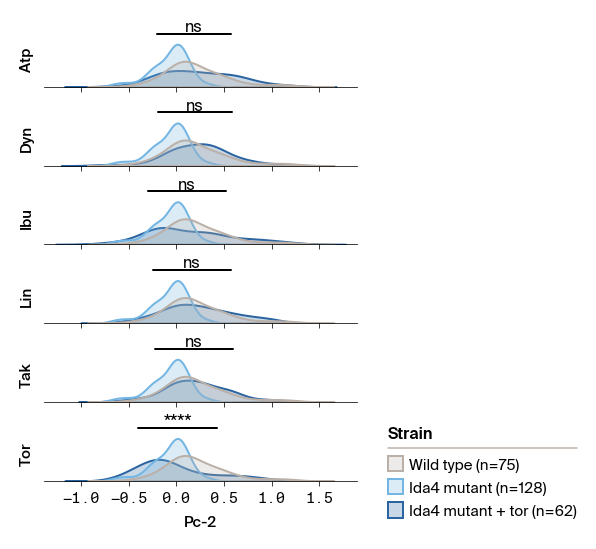

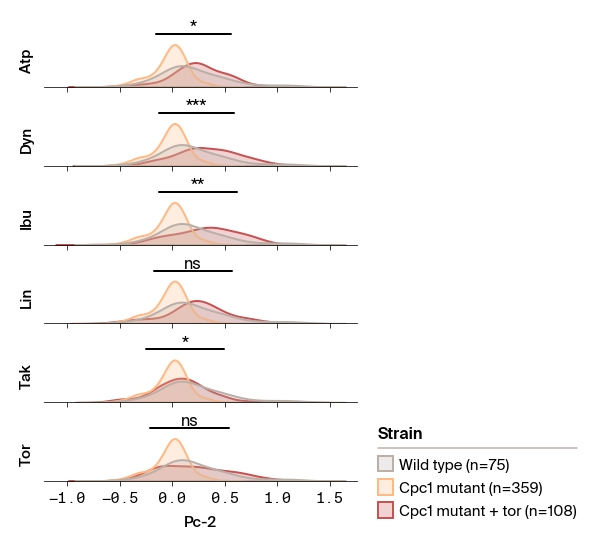

In [11]:
# create filtered dataframe of motility data from wild type cells in controls
motility_dataframe_controlled_wildtype = motility_dataframe_controls.loc[
    motility_dataframe_controls["strain"] == wild_type
]

for mutant_strain in mutant_strains:
    # create filtered dataframe of motility data from mutant cells in controls
    motility_dataframe_controlled_mutant = motility_dataframe_controls.loc[
        motility_dataframe_controls["strain"] == mutant_strain
    ]

    # create figure
    figsize = apc.mpl.get_figure_dimensions("full_square")
    figsize = [1.2 * size for size in figsize]
    fig, axes = plt.subplots(
        nrows=len(drugs),
        layout="constrained",
        sharex=True,
        figsize=figsize,
    )

    for drug, ax in zip(drugs, axes.flat, strict=False):
        # create filtered dataframe of motility data from mutant cells on each drug
        motility_dataframe_drugged_mutant = motility_dataframe.loc[
            (motility_dataframe["strain"] == mutant_strain) & (motility_dataframe["drug"] == drug)
        ].copy()

        # apply min-max normalization to the data
        metrics_drugged_mutants = motility_dataframe_drugged_mutant.loc[:, metrics]
        minmax_range = metrics_drugged_mutants.max() - metrics_drugged_mutants.min()
        metrics_drugged_mutants_normalized = (
            metrics_drugged_mutants - metrics_drugged_mutants.min()
        ) / minmax_range

        # project mutant + drug motility into PC space of wild type + controls
        motility_components = pca_controls.transform(metrics_drugged_mutants_normalized)

        # add principal components to dataframe
        num_components = motility_components.shape[1]
        for i in range(num_components):
            key = f"PC-{i + 1}"
            motility_dataframe_drugged_mutant[key] = motility_components[:, i]

        # combine groups whose motility we want to examine
        source = pd.concat(
            [
                motility_dataframe_controlled_wildtype,
                motility_dataframe_controlled_mutant,
                motility_dataframe_drugged_mutant,
            ]
        )

        # give each of the three groups unique labels so they can be separated in the plot
        source["Strain"] = source["strain"].map(rename_for_plot)
        for i, row in source.iterrows():
            if row["drug"] in drugs:
                source.loc[i, "Strain"] += f" + {drug}"
        # define groups for statistical tests -- only want to compare wild type and mutant + drug
        a = f"{rename_for_plot[mutant_strain]} + {drug}"
        groups = ["wild type", a]

        # plot the joint distributions for the first two principal components
        legend = False if drug != drugs[-1] else True
        kdeplot = kde_plot_with_stats(
            data=source,
            x_variable="PC-2",
            hue_variable="Strain",
            groups=groups,
            legend=legend,
            palette=color_palette,
            common_norm=False,
            fill=True,
            lw=2,
            ax=ax,
        )

        # aesthetics
        ax.set_ylabel(drug)
        ax.yaxis.set_ticks([])
        sns.despine(ax=ax, left=True)
        if legend:
            sns.move_legend(ax, "upper right", bbox_to_anchor=(1.7, 1))
        apc.mpl.style_plot(ax, monospaced_axes="both")